<a href="https://colab.research.google.com/github/Iftekhar-mobin/TimeSeriesLSTM/blob/main/Multivariate_Multi_Step_Medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference : https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

Reference : https://towardsdatascience.com/predictive-analytics-time-series-forecasting-with-gru-and-bilstm-in-tensorflow-87588c852915

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from numpy import mean , concatenate
from math import sqrt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
df = pd.read_csv('GBPUSD1440.csv',delimiter=',')
df.columns =['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume']

In [3]:
df = df[['Open', 'High', 'Low', 'Close']]

In [4]:
df['avg'] = df.loc[:, ['Open', 'High', 'Low', 'Close']].mean(axis=1)

In [5]:
df

,Open,High,Low,Close,avg
0,1.24212,1.24671,1.23587,1.24252,1.241805
1,1.24250,1.24928,1.24003,1.24497,1.244195
2,1.24494,1.24800,1.24139,1.24738,1.245427
3,1.24585,1.24799,1.24482,1.24782,1.246620
4,1.24781,1.25296,1.23839,1.24064,1.244950
...,...,...,...,...,...
2043,1.25792,1.25990,1.24864,1.25140,1.254465
2044,1.25139,1.26242,1.25128,1.26059,1.256420
2045,1.26058,1.26985,1.26001,1.26702,1.264365
2046,1.26703,1.27900,1.26291,1.27841,1.271837


In [11]:
df['ema_short'] = df['avg'].ewm(span=5, adjust=False).mean()
df['ema_mid'] = df['avg'].ewm(span=11, adjust=False).mean()
df['ema_long'] = df['avg'].ewm(span=24, adjust=False).mean()
df['ema_long_long'] = df['avg'].ewm(span=50, adjust=False).mean()

<Axes: >

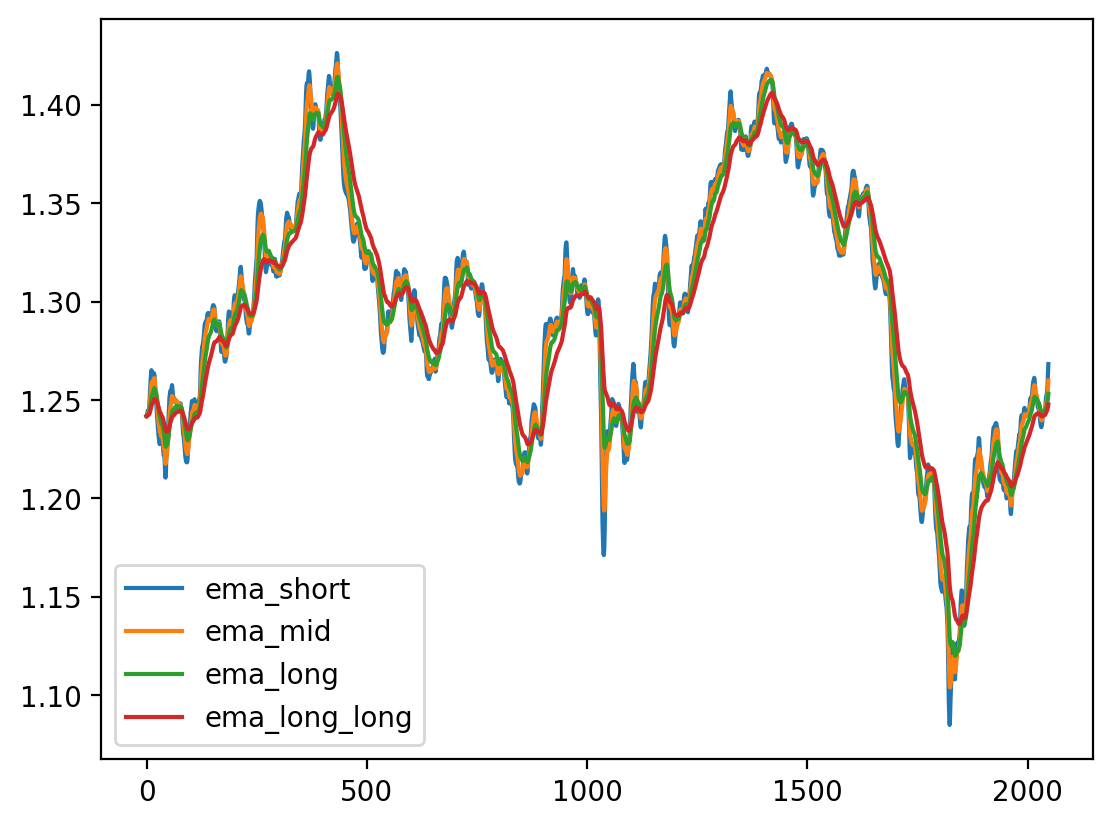

In [16]:
df.iloc[:,-4:].plot()

In [17]:
dataset = df

In [18]:
x_1 = dataset['ema_short']
x_2 = dataset['ema_mid']
x_3 = dataset['ema_long']
x_4 = dataset['ema_long_long']
y = dataset['avg']

x_1 = x_1.values
x_2 = x_2.values
x_3 = x_3.values
x_4 = x_4.values
y = y.values

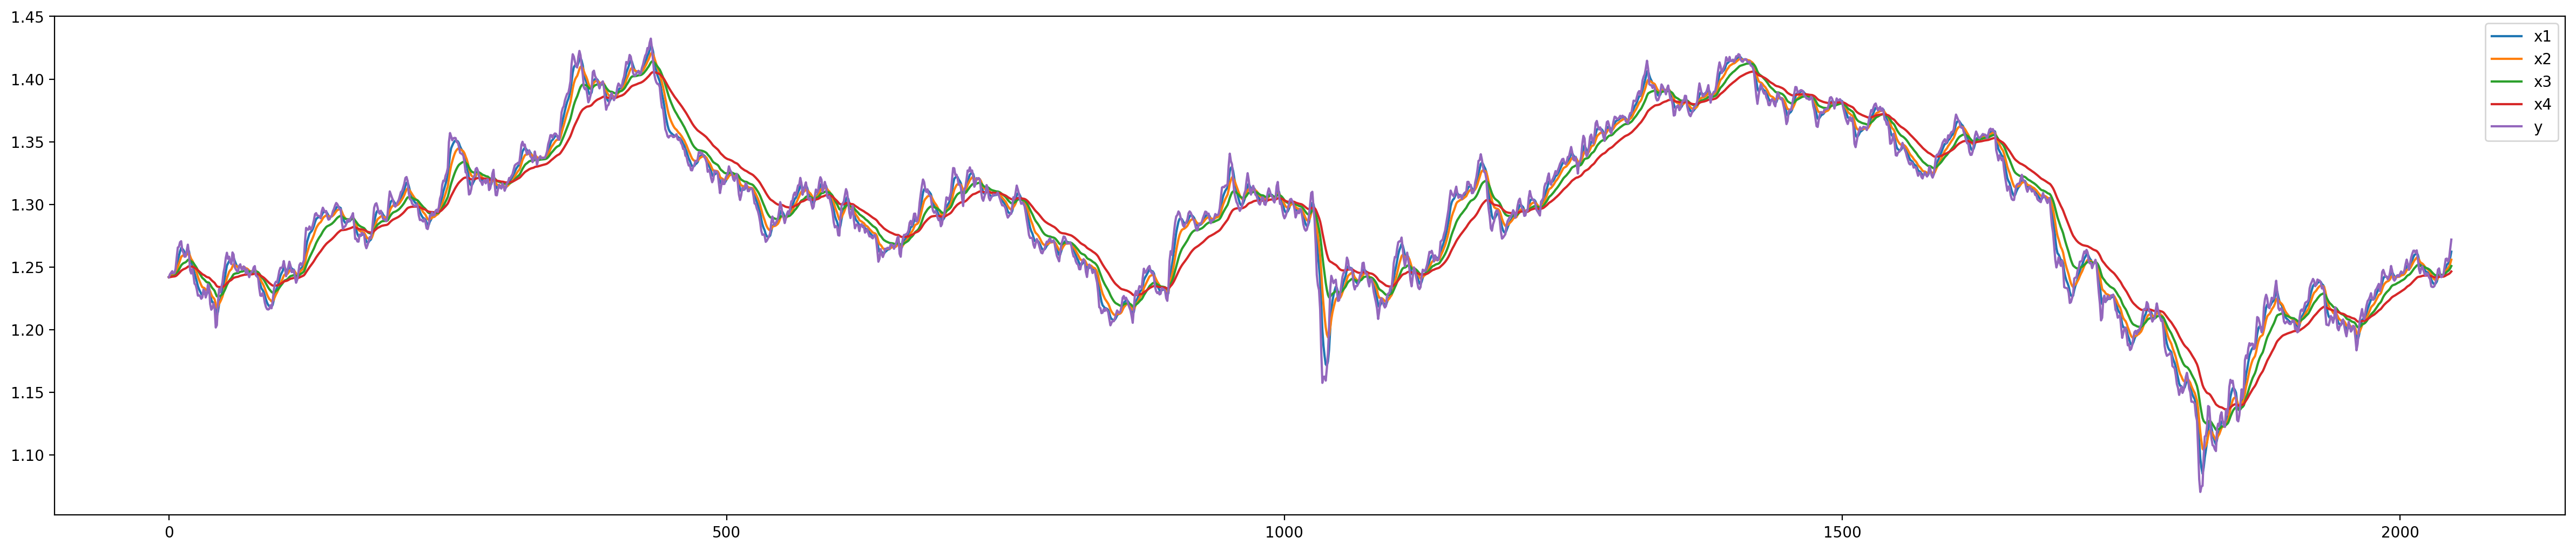

In [19]:
plt.figure(figsize=(30, 6))
plt.plot(x_1[:-1] , label='x1')
plt.plot(x_2[:-1] , label='x2')
plt.plot(x_3[:-1] , label='x3')
plt.plot(x_4[:-1] , label='x4')
plt.plot(y[:-1] , label='y')
plt.legend(loc='upper right')
# plt.title("Dataset" ,  fontsize=18)
# plt.xlabel('Time step' ,  fontsize=18)
# plt.ylabel('Values' , fontsize=18)
plt.legend()
plt.show()

In [20]:
# convert to [rows, columns] structure
x_1 = x_1.reshape((len(x_1), 1))
x_2 = x_2.reshape((len(x_2), 1))
x_3 = x_2.reshape((len(x_3), 1))
x_4 = x_2.reshape((len(x_4), 1))
y = y.reshape((len(y), 1))

print ("x_1.shape" , x_1.shape)
print ("x_2.shape" , x_2.shape)
print ("y.shape" , y.shape)

x_1.shape (2048, 1)
x_2.shape (2048, 1)
y.shape (2048, 1)


In [21]:
# normalization features
scaler = MinMaxScaler(feature_range=(0, 1))
x_1_scaled = scaler.fit_transform(x_1)
x_2_scaled = scaler.fit_transform(x_2)
x_3_scaled = scaler.fit_transform(x_3)
x_4_scaled = scaler.fit_transform(x_4)
y_scaled = scaler.fit_transform(y)

# horizontally stack columns
dataset_stacked = hstack((x_1_scaled, x_2_scaled, x_3_scaled, x_4_scaled, y_scaled))

print ("dataset_stacked.shape" , dataset_stacked.shape)

dataset_stacked.shape (2048, 5)


In [22]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


In [23]:
## choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 60 , 20

# covert into input/output
X, y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)

print ("X.shape" , X.shape)
print ("y.shape" , y.shape)

X.shape (1970, 60, 4)
y.shape (1970, 20)


In [24]:
split = int(len(X)*0.9)
train_X , train_y = X[:split, :] , y[:split, :]
test_X , test_y = X[split:, :] , y[split:, :]

n_features = train_X.shape[2]


In [25]:
print ("train_X.shape" , train_X.shape)
print ("train_y.shape" , train_y.shape)
print ("test_X.shape" , test_X.shape)
print ("test_y.shape" , test_y.shape)
print ("n_features" , n_features)

train_X.shape (1773, 60, 4)
train_y.shape (1773, 20)
test_X.shape (197, 60, 4)
test_y.shape (197, 20)
n_features 4


**LSTM Model Parameter Setting**

In [38]:
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))
# model.add(Activation('linear'))
model.compile(loss='mse' , optimizer='adam' , metrics=['mse'])


In [39]:
# Fit network
history = model.fit(train_X , train_y , epochs=20 , steps_per_epoch=25 , verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False)


Epoch 1/20
25/25 [==============================] - 8s 190ms/step - loss: 0.3235 - mse: 0.3235 - val_loss: 0.1091 - val_mse: 0.1091
Epoch 2/20
25/25 [==============================] - 5s 188ms/step - loss: 0.2330 - mse: 0.2330 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 3/20
25/25 [==============================] - 8s 301ms/step - loss: 0.1869 - mse: 0.1869 - val_loss: 0.0618 - val_mse: 0.0618
Epoch 4/20
25/25 [==============================] - 8s 309ms/step - loss: 0.1153 - mse: 0.1153 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 5/20
25/25 [==============================] - 8s 332ms/step - loss: 0.0806 - mse: 0.0806 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 6/20
25/25 [==============================] - 8s 305ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 7/20
25/25 [==============================] - 7s 304ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 8/20
25/25 [==============================] - 8s 317ms/step - loss: 0.

Evaluation



In [40]:
# Test Data Batch 1 , Test Data Batch 2 , Test Data Batch 3
url_test = 'H4_EURUSD.csv'
dataset_test_ok = pd.read_csv(url_test, usecols=['open', 'high', 'low', 'close'])
dataset_test_ok = dataset_test_ok.iloc[:500, :]
dataset_test_ok['avg'] = dataset_test_ok.iloc[:,0:-1].mean(axis=1)

dataset_test_ok['ema_short_test'] = dataset_test_ok['avg'].ewm(span=5, adjust=False).mean()
dataset_test_ok['ema_mid_test'] = dataset_test_ok['avg'].ewm(span=11, adjust=False).mean()
dataset_test_ok['ema_long_test'] = dataset_test_ok['avg'].ewm(span=24, adjust=False).mean()
dataset_test_ok['ema_long_long_test'] = dataset_test_ok['avg'].ewm(span=50, adjust=False).mean()


dataset_test_ok.head()

,open,high,low,close,avg,ema_short_test,ema_mid_test,ema_long_test,ema_long_long_test
0,1.0088,1.0106,1.0061,1.0062,1.008500,1.008500,1.008500,1.008500,1.008500
1,1.0073,1.0190,1.0073,1.0175,1.011200,1.009400,1.008950,1.008716,1.008606
2,1.0173,1.0181,1.0154,1.0157,1.016933,1.011911,1.010281,1.009373,1.008932
3,1.0154,1.0167,1.0093,1.0115,1.013800,1.012541,1.010867,1.009728,1.009123
4,1.0118,1.0118,1.0054,1.0073,1.009667,1.011583,1.010667,1.009723,1.009145


In [41]:
# read test data
x1_test = dataset_test_ok['ema_short_test'].values
x2_test = dataset_test_ok['ema_mid_test'].values
x3_test = dataset_test_ok['ema_long_test'].values
x4_test = dataset_test_ok['ema_long_long_test'].values
y_test = dataset_test_ok['avg'].values # no need to scale

# convert to [rows, columns] structure
x1_test = x1_test.reshape((len(x1_test), 1))
x2_test = x2_test.reshape((len(x2_test), 1))
x3_test = x3_test.reshape((len(x3_test), 1))
x4_test = x4_test.reshape((len(x4_test), 1))
y_test = y_test.reshape((len(y_test), 1))

x1_test_scaled = scaler.fit_transform(x1_test)
x2_test_scaled = scaler.fit_transform(x2_test)
x3_test_scaled = scaler.fit_transform(x3_test)
x4_test_scaled = scaler.fit_transform(x4_test)


In [42]:
def prep_data(x1_test_scaled , x2_test_scaled , x3_test_scaled, x4_test_scaled, y_test , start , end , last):
    #prepare test data X
    dataset_test = hstack((x1_test_scaled, x2_test_scaled, x3_test_scaled, x4_test_scaled))
    dataset_test_X = dataset_test[start:end, :]
    test_X_new = dataset_test_X.reshape(1, dataset_test_X.shape[0] , dataset_test_X.shape[1])

    #prepare past and groundtruth
    past_data = y_test[:end , :]
    dataset_test_y = y_test[end:last , :]
    scaler1 = MinMaxScaler(feature_range=(0, 1))
    scaler1.fit(dataset_test_y)

    # predictions
    y_pred = model.predict(test_X_new)
    y_pred_inv = scaler1.inverse_transform(y_pred)
    y_pred_inv = y_pred_inv.reshape(n_steps_out,1)
    y_pred_inv = y_pred_inv[:,0]

    return y_pred_inv , dataset_test_y , past_data

# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name , start , end):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print("Test Data from {} to {}".format(start, end))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('')
    print('')

# Plot history and future
def plot_multistep(history, prediction1 , groundtruth , start , end):

    plt.figure(figsize=(20, 4))

    y_mean = mean(prediction1)

    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))

    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with LSTM')
    plt.plot(range_future, np.array(groundtruth),label='GroundTruth')

    plt.legend(loc='upper right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

In [43]:
# Plot history and future
def plot_multistep(history, prediction1 , groundtruth , start , end):
    plt.figure(figsize=(20, 4))
    y_mean = mean(prediction1)
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with LSTM')
    plt.plot(range_future, np.array(groundtruth),label='GroundTruth')
    plt.legend(loc='upper right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

In [45]:
dataset_test_ok.avg.values

array([1.0085    , 1.0112    , 1.01693333, 1.0138    , 1.00966667,
       1.0129    , 1.02363333, 1.02473333, 1.0244    , 1.0242    ,
       1.0291    , 1.0313    , 1.02906667, 1.02923333, 1.0302    ,
       1.0343    , 1.03643333, 1.0354    , 1.0321    , 1.03236667,
       1.0338    , 1.03543333, 1.03726667, 1.0334    , 1.03073333,
       1.03186667, 1.03056667, 1.03003333, 1.02933333, 1.0294    ,
       1.0286    , 1.02883333, 1.02866667, 1.02623333, 1.0235    ,
       1.02506667, 1.02616667, 1.02563333, 1.02703333, 1.02973333,
       1.02866667, 1.03006667, 1.03216667, 1.03313333, 1.0336    ,
       1.03406667, 1.03136667, 1.02923333, 1.03113333, 1.0306    ,
       1.0295    , 1.02936667, 1.0282    , 1.0264    , 1.0259    ,
       1.0257    , 1.02626667, 1.0248    , 1.0231    , 1.01666667,
       1.01423333, 1.01296667, 1.01346667, 1.01233333, 1.01036667,
       1.0092    , 1.01186667, 1.0113    , 1.01036667, 1.01056667,
       1.0091    , 1.01086667, 1.01323333, 1.01473333, 1.01456

1/1 [==============================] - 0s 368ms/step
Test Data from 120 to 180
Mean Absolute Error: 0.00
Root Mean Square Error: 0.00


1/1 [==============================] - 0s 43ms/step
Test Data from 180 to 240
Mean Absolute Error: 0.00
Root Mean Square Error: 0.00




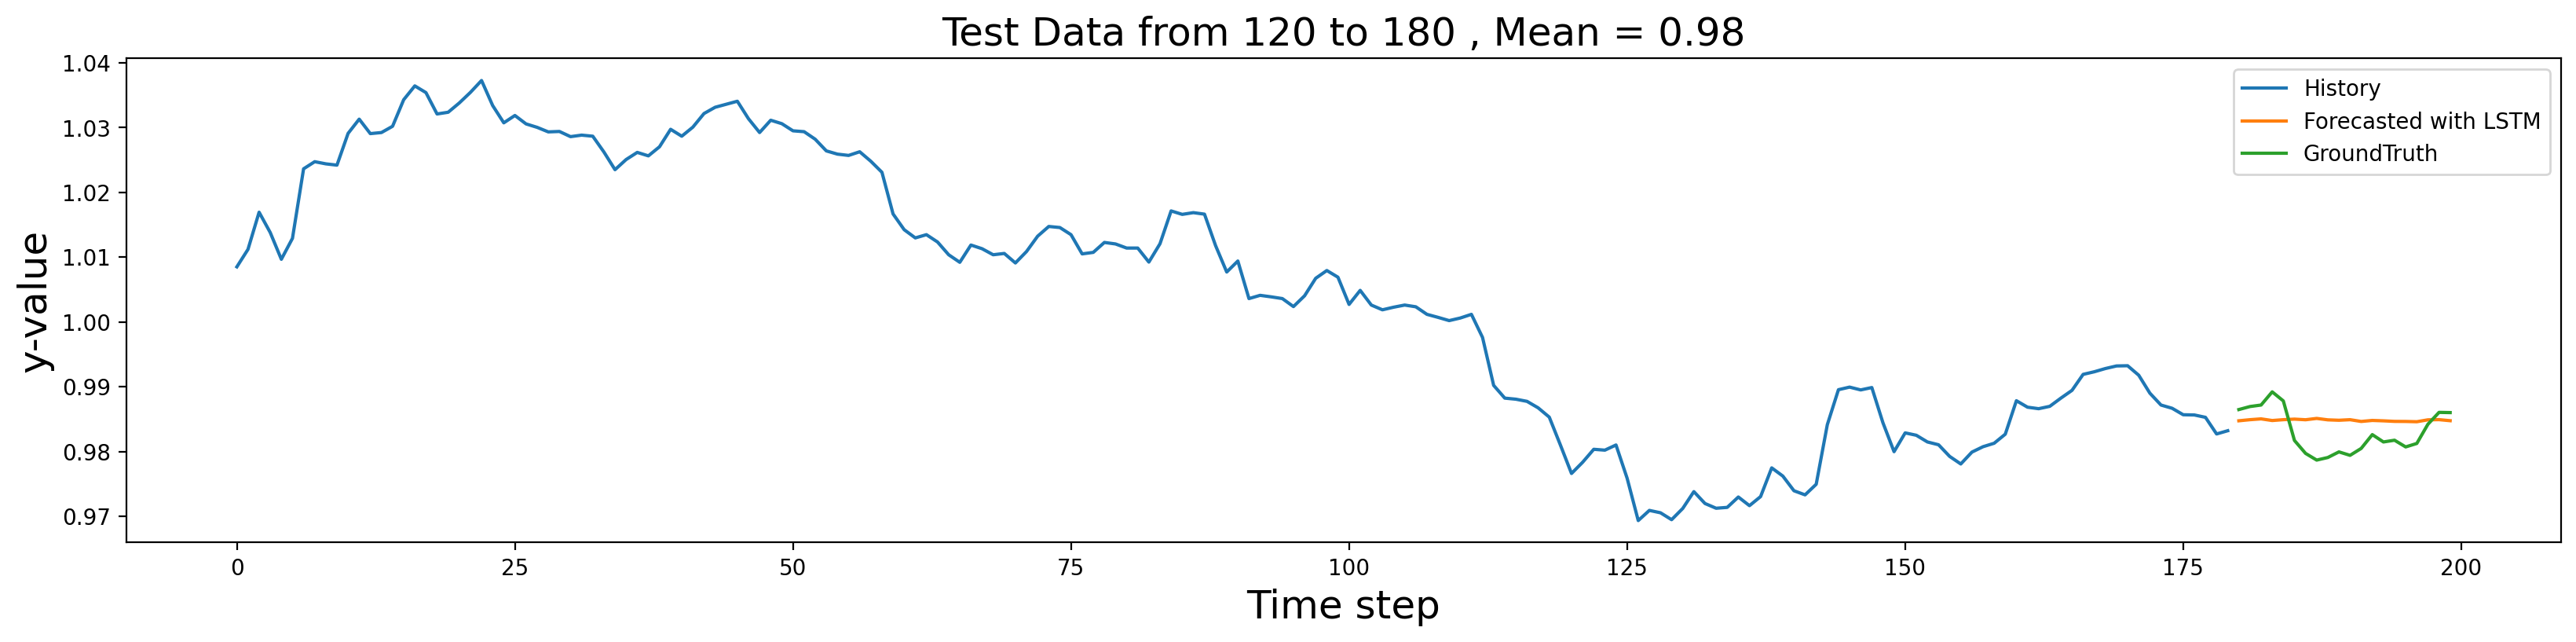

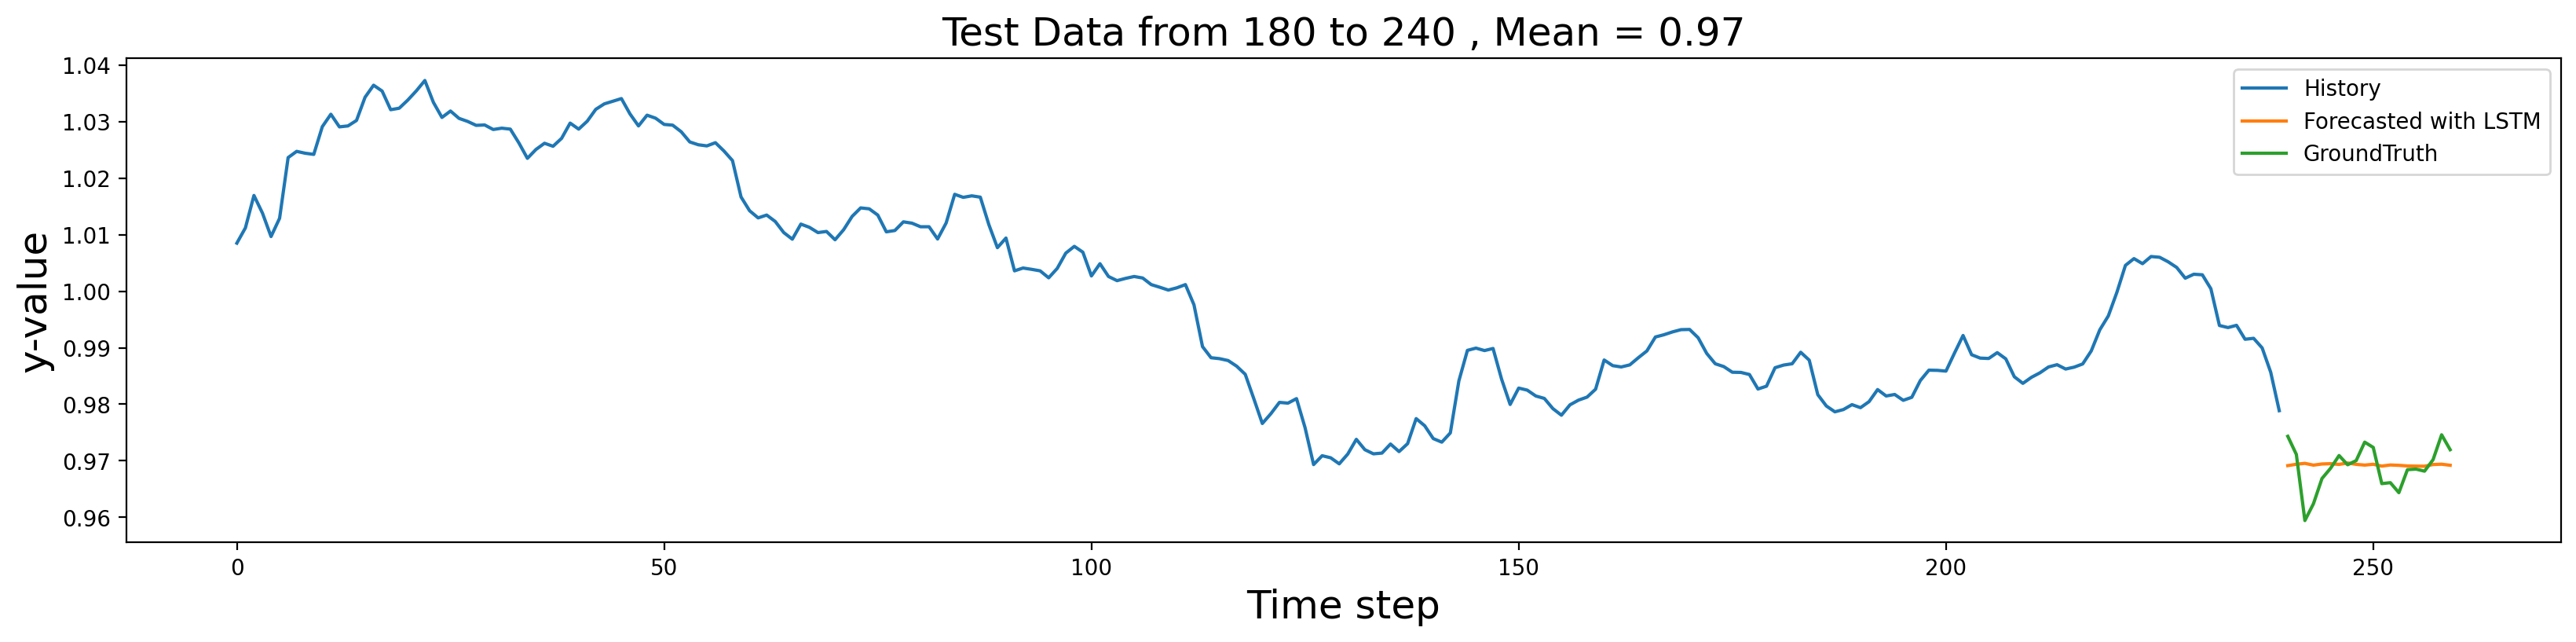

In [44]:
for i in range(120,240,60):
    start = i
    end = start + n_steps_in
    last = end + n_steps_out    
    y_pred_inv , dataset_test_y , past_data = prep_data(x1_test_scaled , x2_test_scaled , x3_test_scaled , x4_test_scaled , y_test , start , end , last)
    evaluate_prediction(y_pred_inv , dataset_test_y, 'LSTM' , start , end)
    plot_multistep(past_data , y_pred_inv , dataset_test_y , start , end)


Save & Load


In [ ]:
# model_url = '/Directory/Filename.h5'
# model.save(model_url)
# print("Saved")

In [ ]:
# model_url = '/Directory/Filename.h5'
# model = load_model(model_url)
# print("Loaded")
# model.summary()